# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

#Machine learning
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Import Data

In [2]:
events_data_test = pd.read_csv('./data_files/stepik_ml/events_data_test.csv')

In [3]:
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [4]:
submission_data_test = pd.read_csv('./data_files/stepik_ml/submission_data_test.csv')

In [5]:
submission_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


# Functions

In [6]:
def make_date_from_timestamp(df):
    'Делаем из timestemp (секунды, которые прошли с 1970 года) datetime объекты: дату и день'
    df['date'] = pd.to_datetime(df.timestamp, unit='s')
    df['day'] = df.date.dt.date
    return df

In [7]:
make_date_from_timestamp(events_data_test).head(3)

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21


In [8]:
def aggregate_events(df, by):
    'Для каждого пользователя расписываем его ивенты (сколько чего выполнено), например, сколько шагов увидел, сколько прошел'
    return df.pivot_table(index='user_id', columns=by,
                          values='step_id', aggfunc='count',
                          fill_value=0).reset_index()

In [9]:
aggregate_events(events_data_test, by='action').head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6


In [10]:
def count_uniq_days_per_user(df):
    'Считает количество уникальных дней для каждого юзера'
    df = df[['user_id', 'day']].drop_duplicates()
    return df.groupby('user_id', as_index=False).count() \
             .rename(columns={'day': 'uniq_days'})

In [11]:
count_uniq_days_per_user(events_data_test).head(3)

,user_id,uniq_days
0,4,1
1,6,1
2,10,1


In [12]:
def count_tried_steps_per_user(df):
    'Считаем степы, которые пользователь попробовал пройти (где есть хоть какое-то действие)'
    return df.groupby('user_id', as_index=False).step_id.nunique() \
             .rename(columns={'step_id': 'uniq_steps'})

In [13]:
count_tried_steps_per_user(events_data_test)[:3]

,user_id,uniq_steps
0,4,1
1,6,1
2,10,2


In [14]:
def step_statistic(df, by):
    'Считаем статистику по каждому степу (сколько раз его смотрели, проходили...)'
    return df.pivot_table(index='step_id', columns=by, 
                          values='user_id', aggfunc='count',
                          fill_value=0).reset_index()

In [15]:
step_statistic(events_data_test, by='action')

action,step_id,discovered,passed,started_attempt,viewed
0,30456,159,159,0,250
1,30462,71,71,0,95
2,30465,56,56,0,70
3,31955,1477,1477,0,2220
4,31956,1618,1618,0,2506
...,...,...,...,...,...
193,109765,23,23,0,27
194,120744,838,838,0,1583
195,120745,1520,1196,1655,2581
196,158432,544,544,0,802


In [58]:
def calculate_user_step_score(events_data, submission_data):
    step_scores = step_statistic(events_data, by='action')
    steps_scores = step_scores.merge(step_statistic(submission_data, by='submission_status'), 
                                 how='outer').fillna(0)
    steps_scores['passed_ratio'] = step_scores.passed / steps_scores.discovered
    difficult_quantile = steps_scores.query('passed_ratio > 0 & passed_ratio < 1').passed_ratio.quantile(0.9)
    steps_scores['is_difficult'] = steps_scores.passed_ratio <= difficult_quantile
    return steps_scores

In [17]:
def count_difficult_steps_per_user(events_data):
    user_difficult_steps = events_data.query('action == "passed"').groupby('user_id', as_index=False) \
                       .aggregate({'action': 'count', 'is_difficult': 'sum'}) \
                       .rename(columns={'action': 'count_steps'})
    user_difficult_steps['difficult_ratio'] = user_difficult_steps.is_difficult / user_difficult_steps.count_steps
    return user_difficult_steps

# Обрабатываем данные

In [18]:
events_data_test = make_date_from_timestamp(events_data_test)
submission_data_test = make_date_from_timestamp(submission_data_test)

In [19]:
submission_data_test.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20


In [20]:
events = aggregate_events(events_data_test, by='action')
user_score = aggregate_events(submission_data_test, by='submission_status')

In [21]:
events.head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6


In [22]:
user_score.head(3)

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,36
2,15,10,30


In [23]:
unique_days = count_uniq_days_per_user(events_data_test)

In [24]:
unique_days.head(3)

,user_id,uniq_days
0,4,1
1,6,1
2,10,1


In [25]:
tried_steps = count_tried_steps_per_user(events_data_test)

In [26]:
tried_steps.head(3)

,user_id,uniq_steps
0,4,1
1,6,1
2,10,2


### Объясняю логику функции calculate_user_step_score()

In [27]:
step_scores = step_statistic(events_data_test, by='action')

In [28]:
steps_scores = step_scores.merge(step_statistic(submission_data_test, by='submission_status'), 
                                 how='outer').fillna(0)

In [29]:
steps_scores['passed_ratio'] = step_scores.passed / steps_scores.discovered

<AxesSubplot:>

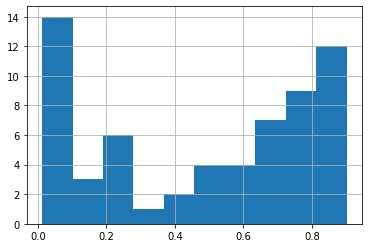

In [30]:
steps_scores.query('passed_ratio > 0 & passed_ratio < 1').passed_ratio.hist()

In [31]:
# Посмотрим, какой passed_ratio (и меньше) у большинства степов (90%)

difficult_quantile = steps_scores.query('passed_ratio > 0 & passed_ratio < 1').passed_ratio.quantile(0.9)
difficult_quantile

0.8597410657334459

In [32]:
# Отметим сложные степы

steps_scores['is_difficult'] = steps_scores.passed_ratio <= difficult_quantile

In [33]:
steps_scores

,step_id,discovered,passed,started_attempt,viewed,correct,wrong,passed_ratio,is_difficult
0,30456,159,159,0,250,0.0,0.0,1.000000,False
1,30462,71,71,0,95,0.0,0.0,1.000000,False
2,30465,56,56,0,70,0.0,0.0,1.000000,False
3,31955,1477,1477,0,2220,0.0,0.0,1.000000,False
4,31956,1618,1618,0,2506,0.0,0.0,1.000000,False
...,...,...,...,...,...,...,...,...,...
193,109765,23,23,0,27,0.0,0.0,1.000000,False
194,120744,838,838,0,1583,0.0,0.0,1.000000,False
195,120745,1520,1196,1655,2581,1473.0,381.0,0.786842,True
196,158432,544,544,0,802,0.0,0.0,1.000000,False


### Строчка нижет содержит в себе весь этот код

In [34]:
steps_scores = calculate_user_step_score(events_data_test, submission_data_test)

In [35]:
steps_scores.head(3)

,step_id,discovered,passed,started_attempt,viewed,correct,wrong,passed_ratio,is_difficult
0,30456,159,159,0,250,0.0,0.0,1.0,False
1,30462,71,71,0,95,0.0,0.0,1.0,False
2,30465,56,56,0,70,0.0,0.0,1.0,False


In [36]:
events_data_test = events_data_test.merge(steps_scores[['step_id', 'passed_ratio', 'is_difficult']])

### Объяснение логики работы count_difficult_steps_per_user()

In [37]:
user_difficult_steps = events_data_test.query('action == "passed"').groupby('user_id', as_index=False) \
                       .aggregate({'action': 'count', 'is_difficult': 'sum'}) \
                       .rename(columns={'action': 'count_steps'})

In [38]:
user_difficult_steps.sort_values('is_difficult', ascending=False)

,user_id,count_steps,is_difficult
949,4736,80,18
4510,21685,135,16
4448,21444,117,15
1514,7374,108,15
2031,9788,113,15
...,...,...,...
1916,9262,20,0
1915,9261,9,0
1914,9260,5,0
1913,9245,1,0


In [39]:
user_difficult_steps['difficult_ratio'] = user_difficult_steps.is_difficult / user_difficult_steps.count_steps

In [40]:
user_difficult_steps.query('difficult_ratio > 0')

,user_id,count_steps,is_difficult,difficult_ratio
4,13,70,4,0.057143
7,21,68,3,0.044118
21,102,76,6,0.078947
41,186,81,7,0.086420
47,207,61,4,0.065574
...,...,...,...,...
5428,26240,72,4,0.055556
5447,26323,60,3,0.050000
5500,26611,40,1,0.025000
5544,26775,103,13,0.126214


### Строчка нижет содержит в себе весь этот код

In [41]:
user_difficult_steps = count_difficult_steps_per_user(events_data_test)

In [42]:
user_difficult_steps.head(3)

,user_id,count_steps,is_difficult,difficult_ratio
0,4,1,0,0.0
1,6,1,0,0.0
2,10,2,0,0.0


### Создаем большой датафрейм, где объединяем все посчитанные данные

In [43]:
user_data = events

In [44]:
user_data = user_data.merge(user_score, how='outer').fillna(0)

In [45]:
user_data.head(3)

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0


In [46]:
user_data = user_data.merge(tried_steps, how='outer')

In [47]:
user_data = user_data.merge(unique_days, how='outer')

In [48]:
user_data['correct_ratio'] = user_data.correct / (user_data.correct + user_data.wrong)

In [49]:
user_data = user_data.fillna(0)

In [50]:
user_data = user_data.merge(user_difficult_steps, on='user_id', how='outer')

In [51]:
user_data.query('difficult_ratio > 0')

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,uniq_steps,uniq_days,correct_ratio,count_steps,is_difficult,difficult_ratio
4,13,70,70,35,105,29.0,36.0,70,2,0.446154,70.0,4.0,0.057143
7,21,74,68,70,98,24.0,103.0,74,2,0.188976,68.0,3.0,0.044118
22,102,77,76,40,113,34.0,48.0,77,3,0.414634,76.0,6.0,0.078947
42,186,85,81,38,101,31.0,18.0,85,2,0.632653,81.0,7.0,0.086420
48,207,61,61,43,112,27.0,63.0,61,3,0.300000,61.0,4.0,0.065574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048,26240,73,72,41,78,28.0,15.0,73,2,0.651163,72.0,4.0,0.055556
6068,26323,61,60,48,86,26.0,53.0,61,3,0.329114,60.0,3.0,0.050000
6131,26611,41,40,17,62,15.0,10.0,41,3,0.600000,40.0,1.0,0.025000
6176,26775,113,103,84,455,46.0,160.0,113,3,0.223301,103.0,13.0,0.126214


In [52]:
user_data = user_data.set_index('user_id')

In [53]:
user_data.drop(['count_steps', 'is_difficult'], axis=1, inplace=True)

In [54]:
user_data.head()

,discovered,passed,started_attempt,viewed,correct,wrong,uniq_steps,uniq_days,correct_ratio,difficult_ratio
user_id,,,,,,,,,,
4,1,1,0,1,0.0,0.0,1,1,0.000000,0.000000
6,1,1,0,1,0.0,0.0,1,1,0.000000,0.000000
10,2,2,0,6,0.0,0.0,2,1,0.000000,0.000000
12,11,9,4,14,1.0,0.0,12,1,1.000000,0.000000
13,70,70,35,105,29.0,36.0,70,2,0.446154,0.057143


In [55]:
user_data = user_data.fillna(0)

In [56]:
user_data.shape

(6184, 10)

# Save data

In [57]:
user_data.to_csv('./data_files/stepik_ml/user_score_test.csv')